In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy import stats
import yaml
from astropy.coordinates import SkyCoord

from gammapy.data import DataStore
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling.models import Models, Model, SkyModel, FoVBackgroundModel
from gammapy.maps import MapAxis, WcsGeom, Map

import warnings
warnings.filterwarnings('ignore')

# choose your source and model

In [2]:
source = 'Crab'
pos = SkyCoord(83.6333313*u.deg, 22.01444435*u.deg, frame='icrs')
mask_sources = [[pos.ra.deg, pos.dec.deg, 0.4]] # given as a list, position and size

from gammapy.modeling.models import GaussianSpatialModel, LogParabolaSpectralModel
spatial=GaussianSpatialModel(lon_0=83.6333313*u.deg, lat_0=22.01444435*u.deg, sigma=0.016*u.deg, reference='1 TeV', frame='icrs')
spectral=LogParabolaSpectralModel(amplitude='3.84e-11 cm-2 s-1 TeV-1', alpha=2.5, beta=0.105, reference='1TeV')
main_source= SkyModel(spatial_model=spatial, spectral_model=spectral, name='main source')

In [3]:
source = 'NGC253'
pos = SkyCoord(83.6333313*u.deg, 22.01444435*u.deg, frame='icrs')
mask_sources = [[pos.ra.deg, pos.dec.deg, 0.4]] # given as a list, position and size

from gammapy.modeling.models import PointSpatialModel, PowerLawSpectralModel
spatial=PointSpatialModel(lon_0=11.8875*u.deg, lat_0=-25.2883*u.deg, reference='1 TeV', frame='icrs')
spectral=PowerLawSpectralModel(amplitude='1.79e-13 cm-2 s-1 TeV-1', index=2.848)
main_source= SkyModel(spatial_model=spatial, spectral_model=spectral, name='main source')

# starting point

In [4]:
# loading general parameters

with open("../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
repo_path=cfg['repo_path']
N_ebins = cfg['N_ebins']
zen_bins = cfg['zen_bins']
energy_bins = np.logspace(-1, 2, N_ebins+1)

In [5]:
stacked = MapDataset.read(f'{source}/stacked.fits')
sys_er = np.loadtxt(f'{source}/sysamplitude.txt')

# checks of dataset

In [6]:
original_mask_safe = stacked.mask_safe.data.copy()
x_axis=stacked.counts.geom.axes['energy'].center.value

for mask_pos in mask_sources:
    stacked.mask_safe &= ~stacked.counts.geom.region_mask(f"icrs;circle({mask_pos[0]}, {mask_pos[1]}, {mask_pos[2]})")

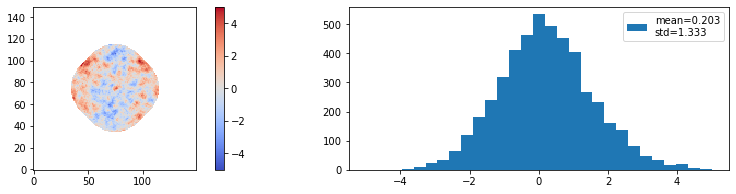

In [7]:
from gammapy.estimators import ExcessMapEstimator

estimator = ExcessMapEstimator(
    correlation_radius="0.2 deg",
    selection_optional=[],
    energy_edges=[0.1, 100] * u.TeV,
)
result = estimator.run(stacked)

fig, ax = plt.subplots(1,2, figsize=(15, 3))
result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ax=ax[0]);
data=result["sqrt_ts"].data.ravel()
ax[1].hist(data, bins=np.linspace(-5,5,30), label=f'mean={np.nanmean(data):.3f}\nstd={np.nanstd(data):.3f}');
plt.legend()

Text(0.5, 0, 'energy [TeV]')

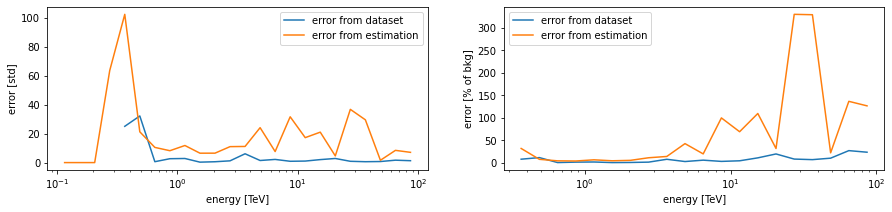

In [8]:
c = np.sum((stacked.counts*stacked.mask_safe).data, axis=(1,2))
b = np.sum((stacked.background*stacked.mask_safe).data, axis=(1,2))
error_std= abs(c-b)/np.sqrt(b)
error_percentage= 100*abs(c-b)/b

fig, ax = plt.subplots(1,2, figsize=(15, 3))

ax[0].plot(x_axis, error_std, label='error from dataset')
ax[0].plot(x_axis, sys_er, label='error from estimation')
ax[0].set_xscale('log')
ax[0].set_ylabel(f'error [std]')
ax[0].legend()
ax[0].set_xlabel('energy [TeV]')

ax[1].plot(x_axis, error_percentage, label='error from dataset')
ax[1].plot(x_axis, 100*sys_er/np.sqrt(b), label='error from estimation')
ax[1].set_xscale('log')
ax[1].set_ylabel(f'error [% of bkg]')
ax[1].legend()
ax[1].set_xlabel('energy [TeV]')

# analysis with gammapy

In [9]:
stacked.models = Models([main_source, FoVBackgroundModel(dataset_name=stacked.name)])
stacked.mask_safe = Map.from_geom(geom=stacked.counts.geom, data=original_mask_safe)   

#stacked.models[-1].parameters['tilt'].frozen=False

In [10]:
print(stacked.models)

DatasetModels

Component 0: SkyModel

  Name                      : main source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      2.848   +/-    0.00             
    amplitude               :   1.79e-13   +/- 0.0e+00 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lon_0                   :     11.887   +/-    0.00 deg         
    lat_0                   :    -25.288   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : EnZjEN7Y-bkg
  Datasets names            : ['EnZjEN7Y']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :      1.000   +/-    0.00             
    tilt         (frozen)   :      0.000                   
    reference    (frozen)   :      1.000       TeV         




In [11]:
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[stacked])

Position <SkyCoord (ICRS): (ra, dec) in deg
    (17.78343615, -25.2883)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (17.78343615, -25.2883)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.99156385, -25.2883)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (5.99156385, -25.2883)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (11.8875, -19.32103867)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (11.8875, -19.32103867)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (11.8875, -31.1371082)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) 

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000214314 is smaller than machine limit 0.0869056 while 0.0002 was requested


In [12]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 125
	total stat : -1458034.34

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 125
	total stat : -1458034.34




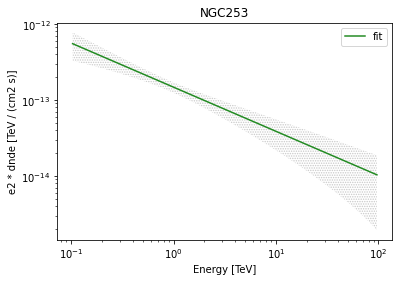

In [13]:
if source == 'Crab':
    from gammapy.modeling.models import create_crab_spectral_model
    crab_types = ['meyer', 'hegra', 'hess_pl', 'hess_ecpl', 'magic_lp']
    for cr in crab_types:
        create_crab_spectral_model(cr).plot(energy_bounds=[0.1, 100]*u.TeV, energy_power=2, label=cr, alpha=0.4)    


stacked.models[0].spectral_model.plot_error(energy_bounds=[0.1, 100]*u.TeV, energy_power=2, facecolor="none", hatch=".....")        
stacked.models[0].spectral_model.plot(energy_bounds=[0.1, 100]*u.TeV, energy_power=2, label='fit', color='forestgreen')
        
plt.legend()
plt.title(source)
plt.show()

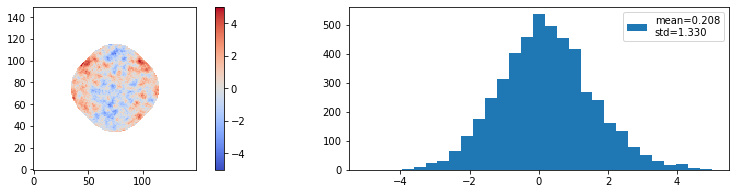

In [14]:
from gammapy.estimators import ExcessMapEstimator

estimator = ExcessMapEstimator(
    correlation_radius="0.2 deg",
    selection_optional=[],
    energy_edges=[0.1, 100] * u.TeV,
)
result = estimator.run(stacked)

fig, ax = plt.subplots(1,2, figsize=(15, 3))
result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ax=ax[0]);
data=result["sqrt_ts"].data.ravel()
ax[1].hist(data, bins=np.linspace(-5,5,30), label=f'mean={np.nanmean(data):.3f}\nstd={np.nanstd(data):.3f}');
plt.legend()

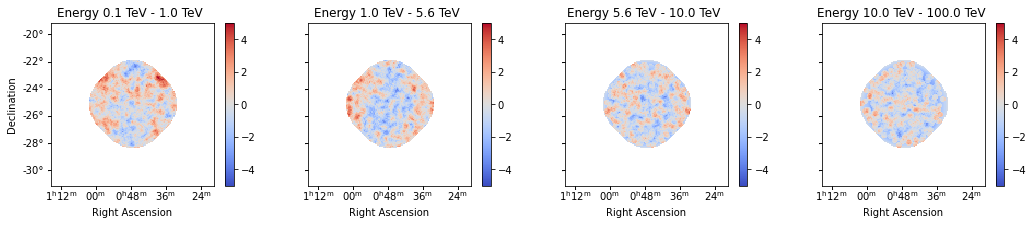

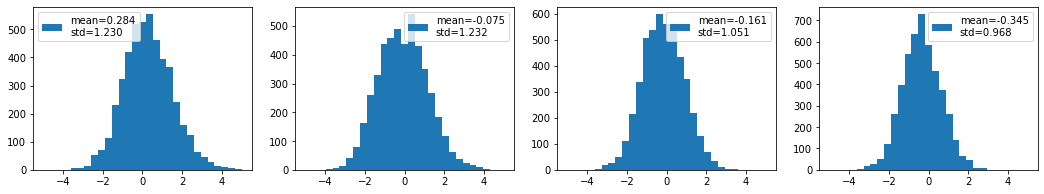

In [15]:
from gammapy.estimators import ExcessMapEstimator

estimator = ExcessMapEstimator(
    correlation_radius="0.2 deg",
    selection_optional=[],
    energy_edges=[0.1,1, 5, 10, 100] * u.TeV,
)
result = estimator.run(stacked)

result["sqrt_ts"].plot_grid(
    figsize=(18, 3), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=4);

fig, ax = plt.subplots(1,4, figsize=(18, 3))

for i in range(4):
    data=result["sqrt_ts"].data[i].ravel()
    ax[i].hist(data, bins=np.linspace(-5,5,30), label=f'mean={np.nanmean(data):.3f}\nstd={np.nanstd(data):.3f}');
    ax[i].legend()

Text(0.5, 0, 'energy [TeV]')

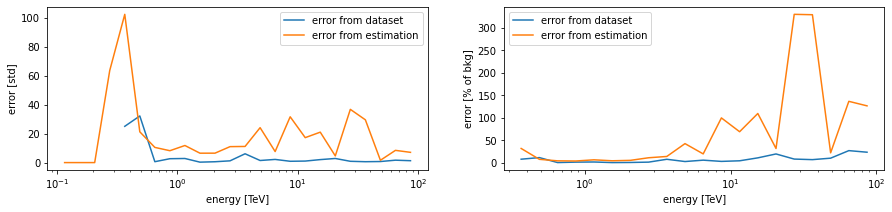

In [16]:
c = np.sum((stacked.counts*stacked.mask_safe).data, axis=(1,2))
b = np.sum((stacked.background*stacked.mask_safe).data, axis=(1,2))
error_std= abs(c-b)/np.sqrt(b)
error_percentage= 100*abs(c-b)/b

fig, ax = plt.subplots(1,2, figsize=(15, 3))

ax[0].plot(x_axis, error_std, label='error from dataset')
ax[0].plot(x_axis, sys_er, label='error from estimation')
ax[0].set_xscale('log')
ax[0].set_ylabel(f'error [std]')
ax[0].legend()
ax[0].set_xlabel('energy [TeV]')

ax[1].plot(x_axis, error_percentage, label='error from dataset')
ax[1].plot(x_axis, 100*sys_er/np.sqrt(b), label='error from estimation')
ax[1].set_xscale('log')
ax[1].set_ylabel(f'error [% of bkg]')
ax[1].legend()
ax[1].set_xlabel('energy [TeV]')